In [1]:
# on the terminal pip install pandas pyarrow

# Q1. Downloading the data

In [56]:
#Read the data for January. How many columns are there?
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
# Read Parquet file
df = pd.read_parquet("yellow_tripdata_2023-01.parquet")

In [57]:
# number of columns Approach 1
num_columns = df.shape[1]
#print(f"Number of columns: {num_columns}")
print("Number of columns:", num_columns)
# alternatively
# Get the number of columns Approach 2
#num_columns = len(df.columns)
#print(f"Number of columns: {num_columns}")

Number of columns: 19


# Q2. Computing duration

In [58]:
# Compute the duration variable (duration of a ride in minutes).
# What's the standard deviation of the trips duration in January?
# creating a new column for the duration in minutes
df["duration_minutes"] = (
    df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
).dt.total_seconds() / 60

In [60]:
# Compute the standard deviation
stdv= df["duration_minutes"].std()
print (f"The standard deviation of the duration in minutes is: {stdv}")

The standard deviation of the duration in minutes is: 42.594351241920904


# Q3. Dropping outliers

In [11]:
# Check the distribution of the duration variable. Remove outliers and keep only the records with duration was between 1 and 60 minutes (inclusive).
#What fraction of the records left after you dropped the outliers?

In [61]:
# Summary Statistics
# Summary stats
print(df["duration_minutes"].describe())

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration_minutes, dtype: float64


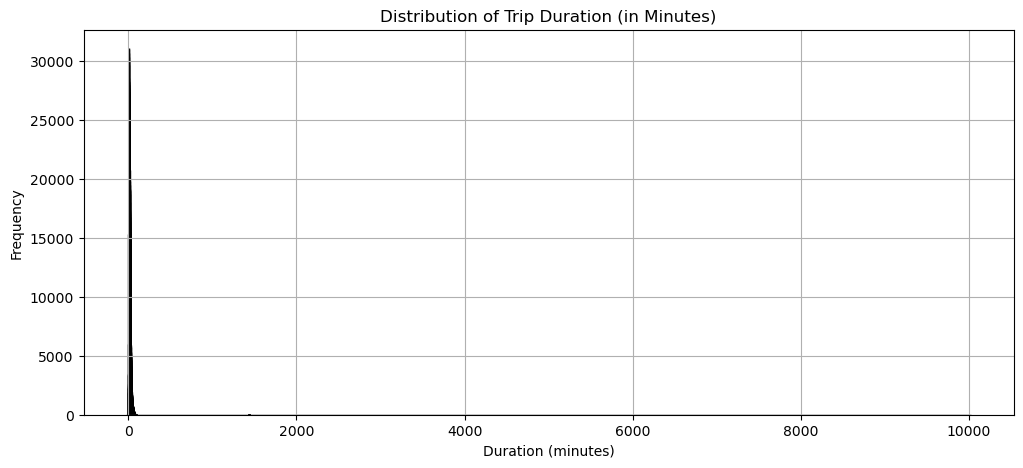

In [69]:
# Visualising the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(df["duration_minutes"], bins= "auto", edgecolor='black')
plt.title("Distribution of Trip Duration (in Minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [12]:
# Total records before filtering
total_before = len(df)

# Keep only durations between 1 and 60 minutes (inclusive)
filtered_df = df[(df["duration_minutes"] >= 1) & (df["duration_minutes"] <= 60)]

# Total records after filtering
total_after = len(filtered_df)


In [13]:
fraction_remaining = total_after / total_before
print(f"Fraction of records remaining after removing outliers: {fraction_remaining:.4f}")


Fraction of records remaining after removing outliers: 0.9812


# Q4. One-hot encoding

In [14]:
#Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.
#Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
#Fit a dictionary vectorizer
#Get a feature matrix from it

from sklearn.feature_extraction import DictVectorizer
# Create a copy after filtering
filtered_df = df[(df["duration_minutes"] >= 1) & (df["duration_minutes"] <= 60)].copy()

# Now safely cast IDs to string
filtered_df["PULocationID"] = filtered_df["PULocationID"].astype(str)
filtered_df["DOLocationID"] = filtered_df["DOLocationID"].astype(str)


In [15]:
# Use only pickup and dropoff location IDs
location_dicts = filtered_df[["PULocationID", "DOLocationID"]].to_dict(orient="records")


In [16]:
# Initialize vectorizer
vec = DictVectorizer(sparse=False)

# Fit and transform the location data
X = vec.fit_transform(location_dicts)

In [17]:
print(f"Feature matrix shape: {X.shape}")
print(f"Feature names: {vec.get_feature_names_out()[:5]} ...")

Feature matrix shape: (3009173, 515)
Feature names: ['DOLocationID=1' 'DOLocationID=10' 'DOLocationID=100' 'DOLocationID=101'
 'DOLocationID=102'] ...


# Q5. Training a model

In [18]:
#Train a plain linear regression model with default parameters, where duration is the response variable
#Calculate the RMSE of the model on the training data
from sklearn.metrics import mean_squared_error
import numpy as np

In [19]:
y = filtered_df["duration_minutes"].values

In [20]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

In [21]:
y_pred = regressor.predict(X)

In [22]:
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

In [23]:
rmse

7.6492612791163355

# Q6. Evaluating the model

In [24]:
df2 = pd.read_parquet("yellow_tripdata_2023-02.parquet")

In [25]:
df2.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          76817
trip_distance                0
RatecodeID               76817
store_and_fwd_flag       76817
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     76817
Airport_fee              76817
dtype: int64

In [46]:
df2["duration_minutes"] = (df2["tpep_dropoff_datetime"] - df2["tpep_pickup_datetime"]).dt.total_seconds() / 60

In [47]:
# Step 2: Filter valid durations
df2 = df2[(df2["duration_minutes"] >= 1) & (df2["duration_minutes"] <= 60)].copy()

In [48]:
# Step 3: Cast to string for vectorizer compatibility
df2["PULocationID"] =df2["PULocationID"].astype(int).astype(str)
df2["DOLocationID"] = df2["DOLocationID"].astype(int).astype(str)

In [49]:
# Step 4 Filter out unknown categories based on training vectorizer
known_features = set(vec.get_feature_names_out())
def is_known(row):
    return f'PULocationID={row["PULocationID"]}' in known_features and f'DOLocationID={row["DOLocationID"]}' in known_features

df2_clean = df2[df2.apply(is_known, axis=1)].copy()

In [51]:
# Step 5: Convert to dicts
val_dicts = df2_clean[["PULocationID", "DOLocationID"]].to_dict(orient="records")

In [52]:
# Step 6: Transform and predict
X_val = vec.transform(val_dicts)
y_val = df2_clean["duration_minutes"].values
y_pred = regressor.predict(X_val)

In [53]:
# Step 8: Compute RMSE
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE on January data: {rmse_val:.2f} minutes")

Validation RMSE on January data: 7.81 minutes
